# Image Classification with Convolutional Neural Networks, CIFAR-10 dataset

In [1]:
from __future__ import absolute_import, division, print_function

In [2]:
import numpy as np
import tensorflow as tf

### Plot graphs inline

In [3]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt

### Download the CIFAR-10 dataset

More information on the dataset can be found here: https://www.cs.toronto.edu/~kriz/cifar.html

The file is 17MB so this might take a while

The dataset is broken into batches to prevent your machine from running out of memory. The CIFAR-10 dataset consists of 5 batches, named data_batch_1, data_batch_2, etc.. Each batch contains the labels and images that are one of the following:

* 0 - airplane
* 1 - automobile
* 2 - bird
* 3 - cat
* 4 - deer
* 5 - dog
* 6 - frog
* 7 - horse
* 8 - ship
* 9 - truck

In [4]:
from six.moves import urllib

CIFAR_10_FILE_NAME = 'cifar-10/cifar-10-python.tar.gz'

urllib.request.urlretrieve(
    'https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz',
    CIFAR_10_FILE_NAME)

('cifar-10/cifar-10-python.tar.gz', <http.client.HTTPMessage at 0x11dee29b0>)

### Untar and unzip the files

* The extracted files (one for each batch) are placed in the folder *cifar-10-batches-py/* under your current working directory 
* Each file is named *data_batch_1, data_batch_2* etc.

In [5]:
import tarfile

with tarfile.open('cifar-10/cifar-10-python.tar.gz') as tar:
    tar.extractall()
    tar.close()

### Load and pre-process files

* Access the image and the labels from a single batch specified by id (1-5)
* Reshape the images, the images are **fed to the convolutional layer as a 4-D tensor**, notice that the reshape has the channels at axis index 1 
* Transpose the axes of the reshaped image to be in this form: *[batch_size, height, width, channels]*, **channels should be the last axis**

In [6]:
import pickle

CIFAR10_DATASET_FOLDER = "cifar-10-batches-py"

def load_cifar10_batch(batch_id):
    with open(CIFAR10_DATASET_FOLDER + '/data_batch_' + str(batch_id), mode='rb') as file:
        batch = pickle.load(file, encoding='bytes')
        
    features = batch[b'data'].reshape((len(batch[b'data']), 3, 32, 32)).transpose(0, 2, 3, 1)
    labels = batch[b'labels']

    return features, labels

features, labels = load_cifar10_batch(1)

### Explore the data

In [7]:
len(features) #10000 images

10000

In [8]:
features[0].shape

(32, 32, 3)

In [9]:
labels[0]

6

### Helper functions to display images as well as labels

* Map the integer labels to the actual labels for display
* Plot the image

In [10]:
lookup = ['airplane', 
          'automobile', 
          'bird', 
          'cat', 
          'deer', 
          'dog', 
          'frog', 
          'horse', 
          'ship', 
          'truck']

def display_feature_label(features, labels, index):
    if index >= len(features):
        raise Error("index out of range")
        
    print("Label: ", lookup[labels[index]])
    plt.imshow(features[index])

Label:  automobile


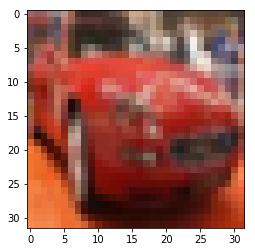

In [11]:
display_feature_label(features, labels, 5)

### Access the *training* data and the corresponding labels

Each batch in the CIFAR-10 dataset has randomly picked images, so the images come pre-shuffled


In [12]:
train_size = int(len(features) * 0.8)

training_images = features[:train_size,:,:]

training_labels = labels[:train_size]

print("Training images: ", len(training_images))
print("Training labels: ", len(training_labels))

Training images:  8000
Training labels:  8000


### Access the *test* data and the corresponding labels

In [13]:
test_images = features[train_size:,:,:]

test_labels = labels[train_size:]

print("Test images: ", len(test_images))
print("Test labels: ", len(test_labels))

Test images:  2000
Test labels:  2000


### The CIFAR-10 dataset has color images

* Each image is of size 32x32
* The image is RGB so has 3 channels, and requires 3 numbers to represent each pixel

In [14]:
height = 32
width = 32
channels = 3
n_inputs = height * width

In [15]:
tf.reset_default_graph()

### Placeholders for training data and labels

* The training dataset placeholder can have any number of instances and each instance is an array of 32x32 pixels (we've already reshaped the data earlier)
* The images are fed to the convolutional layer as a 4D tensor *[batch_size, height, width, channels]*

In [16]:
X = tf.placeholder(tf.float32, shape=[None,  height, width, channels], name="X")

### Add a dropout layer to avoid overfitting the training data

* The training flag is set to False during prediction and is True while training (dropout is applied only in the training phase)
* The dropout_rate indicates the chances that a neuron is turned off during training
* Here 30% of the neurons will be dropped off at somepoint in the training process

In [17]:
dropout_rate = 0.3

training = tf.placeholder_with_default(False, shape=(), name='training')
X_drop = tf.layers.dropout(X, dropout_rate, training=training)

In [18]:
y = tf.placeholder(tf.int32, shape=[None], name="y")

### Neural network design

* 2 convolutional layers
* 1 max pooling layer
* 1 convolutional layer
* 1 max pooling layer
* 2 fully connected layers
* Output logits layer

In [19]:
conv1 = tf.layers.conv2d(X_drop, filters=32,
                         kernel_size=3,
                         strides=1, padding="SAME",
                         activation=tf.nn.relu, name="conv1")

In [20]:
conv2 = tf.layers.conv2d(conv1, filters=64, 
                         kernel_size=3,
                         strides=2, padding="SAME",
                         activation=tf.nn.relu, name="conv2")

In [21]:
conv2.shape

TensorShape([Dimension(None), Dimension(16), Dimension(16), Dimension(64)])

### Pooling reduces the size of the image

The pooled image is only 1/4th the size of the original image with this kernel size and stride

In [22]:
pool3 = tf.nn.max_pool(conv2,
                       ksize=[1, 2, 2, 1],
                       strides=[1, 2, 2, 1],
                       padding="VALID") #no zero padding

In [23]:
conv4 = tf.layers.conv2d(pool3, filters=128, 
                         kernel_size=4,
                         strides=3, padding="SAME",
                         activation=tf.nn.relu, name="conv4")

### Reshape the pooled layer to be a 1-D vector (flatten it) 

In [24]:
pool5 = tf.nn.max_pool(conv4,
                       ksize=[1, 2, 2, 1],
                       strides=[1, 1, 1, 1],
                       padding="VALID")

In [25]:
pool5.shape

TensorShape([Dimension(None), Dimension(2), Dimension(2), Dimension(128)])

In [26]:
pool5_flat = tf.reshape(pool5, shape=[-1, 128 * 2 * 2])

In [27]:
fullyconn1 = tf.layers.dense(pool5_flat, 128,
                             activation=tf.nn.relu, name="fc1")

In [28]:
fullyconn2 = tf.layers.dense(fullyconn1, 64,
                             activation=tf.nn.relu, name="fc2")

### There are 10 possible classifications in the CIFAR-10 dataset

The number of outputs of the logits layer should be 10

In [29]:
logits = tf.layers.dense(fullyconn2, 10, name="output")

### The final output layer with softmax activation

The *tf.nn.sparse_softmax_cross_entropy_with_logits* will apply the softmax activation as well as calculate the cross-entropy as our cost function

In [30]:
xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits,
                                                          labels=y)
loss = tf.reduce_mean(xentropy)
optimizer = tf.train.AdamOptimizer()
training_op = optimizer.minimize(loss)

### Check correctness and accuracy of the prediction

* Check whether the highest probability output in logits is equal to the y-label
* Check the accuracy across all predictions (How many predictions did we get right?)

In [31]:
correct = tf.nn.in_top_k(logits, y, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

In [32]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

### Set up a helper method to access training data in batches

In [33]:
def get_next_batch(features, labels, train_size, batch_index, batch_size):
    training_images = features[:train_size,:,:]
    training_labels = labels[:train_size]
    
    test_images = features[train_size:,:,:]
    test_labels = labels[train_size:]
    
    start_index = batch_index * batch_size
    end_index = start_index + batch_size

    return features[start_index:end_index,:,:], labels[start_index:end_index], test_images, test_labels

### Train and evaluate the model

* For smaller training data you'll find that the model performs poorly, it improves as you increase the size of the training data (use all batches)
* Ensure that dropout is enabled during training to avoid overfitting

In [34]:
n_epochs = 10
batch_size = 128

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
#         batch_index = 0
        # Add this in when we want to run the training on all batches in CIFAR-10
        for batch_id in range(1, 6):
            batch_index = 0
            
            features, labels = load_cifar10_batch(batch_id)
            train_size = int(len(features) * 0.8)
            
            for iteration in range(train_size // batch_size):
                X_batch, y_batch, test_images, test_labels = get_next_batch(features, 
                                                                            labels, 
                                                                            train_size, 
                                                                            batch_index,
                                                                            batch_size)
                batch_index += 1

                sess.run(training_op, feed_dict={X: X_batch, y: y_batch, training: True})

        acc_train = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        acc_test = accuracy.eval(feed_dict={X: test_images, y: test_labels})
        print(epoch, "Train accuracy:", acc_train, "Test accuracy:", acc_test)

        save_path = saver.save(sess, "./my_mnist_model")

0 Train accuracy: 0.234375 Test accuracy: 0.304
1 Train accuracy: 0.3125 Test accuracy: 0.343
2 Train accuracy: 0.351562 Test accuracy: 0.3575
3 Train accuracy: 0.359375 Test accuracy: 0.3815
4 Train accuracy: 0.4375 Test accuracy: 0.448
5 Train accuracy: 0.429688 Test accuracy: 0.453
6 Train accuracy: 0.492188 Test accuracy: 0.482
7 Train accuracy: 0.5 Test accuracy: 0.492
8 Train accuracy: 0.515625 Test accuracy: 0.4975
9 Train accuracy: 0.507812 Test accuracy: 0.528
